In [108]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import torchvision.utils as vutils
from torch.utils.data import WeightedRandomSampler, DataLoader, Dataset
from collections import OrderedDict

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd

import seaborn as sns

In [109]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('running on:', device)

running on: cuda:0


In [110]:
IMG_SIZE = 48

CLASSES = ['neutral', 'happy', 'surprised', 'sad', 'angry', 'disgusted', 'afraid']
NUM_CLASSES = len(CLASSES)

## Pre-processing

In [111]:
df_fer = pd.read_csv('data/fer2013.csv').iloc[:, 1:]
df_ferplus = pd.read_csv('data/ferplus2013.csv').iloc[:, 2:-3]
df = df_fer.join(df_ferplus)
# df.head(15)

df['emotion'] = df.iloc[:, 2:].idxmax(axis=1).tolist()
df = df.replace(dict(zip(pd.Series(CLASSES),pd.Series(CLASSES).index)))
# df.head(15)

print('number of images:', df.shape[0])
df = df[(df.iloc[:, 2:-1].max(axis=1) > 5)]
print('after removing images with unknown/unsure classification:', df.shape[0])
# df.head(15)

df = df.iloc[:, [0, 1, -1]]
# df.head(15)

number of images: 35887
after removing images with unknown/unsure classification: 27307


In [112]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(30),
    transforms.ToTensor()
])

images_np = np.array(df['pixels'])
label_np = np.array(df['emotion'])

images = []
labels = []

for i in range(df.shape[0]):
    b = bytes(int(p) for p in images_np[i].split())
    img = Image.frombuffer('L', (IMG_SIZE, IMG_SIZE), b)
    images.append(transform(img))
    labels.append(label_np[i])

In [113]:
label_counts = [0]*NUM_CLASSES

for i in range(len(labels)):
    label_counts[labels[i]] += 1

print('\033[4m{: <15} {: >10}\033[0m'.format('class', '#images'))
for i in range(NUM_CLASSES):
    print('{: <15} {: >10}'.format(CLASSES[i], label_counts[i]))

class              #images
neutral               9494
happy                 8802
surprised             3461
sad                   2958
angry                 2096
disgusted               66
afraid                 430


In [114]:
train_split_pct = 0.8
train_len = int(len(labels) * train_split_pct)

train_images = images[:train_len]
train_labels = labels[:train_len]
test_images = images[train_len:]
test_labels = labels[train_len:]

print(f'train length: {len(train_labels)} ({len(train_labels)*100/len(labels):.1f}%)')
print(f'test length: {len(test_labels)} ({len(test_labels)*100/len(labels):.1f}%)')

train length: 21845 (80.0%)
test length: 5462 (20.0%)


In [115]:
BATCH_SIZE = 64


class CustomDataset(Dataset):
    
    def __init__(self, images, labels):      
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


train_dataset = CustomDataset(train_images, train_labels)
test_dataset = CustomDataset(test_images, test_labels)


def get_loader(dataset):
    print('get_loader():')

    label_counts = [0]*NUM_CLASSES
    for i in range(len(dataset.labels)):
        label_counts[dataset.labels[i]] += 1

    class_weights = pow(np.array(label_counts) / sum(label_counts), -1)
    print('  class weights:', class_weights.round(3), '\n')

    sample_weights = [0]*len(dataset)
    for idx, (image, label) in enumerate(dataset):
        sample_weights[idx] = class_weights[label]

    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    return DataLoader(dataset, BATCH_SIZE, sampler=sampler, shuffle=False)


train_loader = get_loader(train_dataset)
test_loader = get_loader(test_dataset)

get_loader():
  class weights: [  2.899   3.07    7.906   9.129  13.231 474.891  63.874] 

get_loader():
  class weights: [  2.788   3.238   7.825   9.667  12.274 273.1    62.068] 



In [116]:
samples_train = [0]*NUM_CLASSES
samples_test = [0]*NUM_CLASSES

for idx, (images, labels) in enumerate(train_loader):
    for i in range(len(images)):
        samples_train[labels[i].item()] += 1

for idx, (images, labels) in enumerate(test_loader):
    for i in range(len(images)):
        samples_test[labels[i].item()] += 1


print('\033[4m{: <15} {: >15} {: >20}\033[0m'.format('class', '#samples (train)', '#samples (test)'))
for i in range(NUM_CLASSES):
    print('{: <15} {: >15} {: >20}'.format(CLASSES[i], samples_train[i], samples_test[i]))

class           #samples (train)      #samples (test)
neutral                    3093                  792
happy                      3113                  775
surprised                  3064                  750
sad                        3140                  811
angry                      3099                  774
disgusted                  3211                  768
afraid                     3125                  792


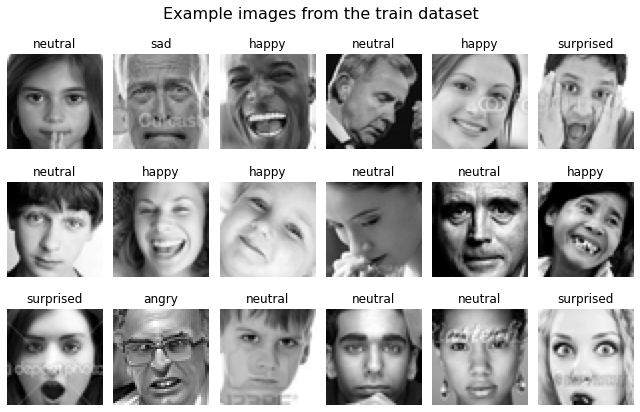

In [117]:
def imshow(dataset, title='', num_images=(3,6), rand=True):

    plt.figure(figsize=(num_images[1]*1.5, num_images[0]*2)); 
    plt.suptitle(title, fontsize=16)

    for i in range(num_images[0]):
        for j in range(num_images[1]):
            
            c = num_images[1]*i+(j+1)

            if not rand:
                idx = c
            else:
                idx = random.randint(0, len(dataset)-1)

            plt.subplot(num_images[0], num_images[1], c); plt.axis('off'); plt.title(CLASSES[dataset[idx][1]])
            plt.imshow(dataset[idx][0].permute(1,2,0), cmap='gray')

    plt.tight_layout(); plt.show()


imshow(train_dataset, 'Example images from the train dataset')

In [118]:
loss_train = []
accuracy_train = []

def train_model(model, criterion, optimizer):
    model.train()
    loss = 0.0
    corrects = 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = criterion(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss += loss.item()
        corrects += (pred.argmax(1) == y).type(torch.float).sum().item()


    epoch_loss = loss / len(train_dataset)
    epoch_accuracy = corrects / len(train_dataset)
    loss_train.append(epoch_loss)
    accuracy_train.append(epoch_accuracy)

    print(f'  TRAIN\t loss: {epoch_loss:.4f}  |  accuracy: {epoch_accuracy:.4f}')

#####

loss_test = []
accuracy_test = []
y_actual = []
y_pred = []

def test_model(model, criterion):
    model.eval()
    loss = 0.0
    corrects = 0
    
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)

        with torch.no_grad():
            pred = model(X)

        y_actual.extend(y.cpu())
        y_pred.extend(pred.argmax(1).cpu())
        
        loss = criterion(pred, y)
        loss += loss.item()
        corrects += (pred.argmax(1) == y).type(torch.float).sum().item()


    epoch_loss = loss / len(test_dataset)
    epoch_accuracy = corrects / len(test_dataset)
    loss_test.append(epoch_loss)
    accuracy_test.append(epoch_accuracy)

    print(f'  TEST\t loss: {epoch_loss:.4f}  |  accuracy: {epoch_accuracy:.4f}')

In [119]:
class CNN(nn.Module):
    def __init__(self, n_features):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_features, kernel_size=5)
        self.conv2 = nn.Conv2d(n_features, n_features, kernel_size=5)

        self.conv2_drop = nn.Dropout2d()
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(n_features*9*9, 1024)
        self.fc2 = nn.Linear(1024, NUM_CLASSES)   
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [120]:
model_cnn = CNN(25)
model_cnn.to(device)

EPOCHS = 50
LEARNING_RATE = 0.01
MOMENTUM = 0.9

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_cnn.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

print(model_cnn)
print('Number of parameters: {}'.format(sum(p.numel() for p in model_cnn.parameters() if p.requires_grad)))

CNN(
  (conv1): Conv2d(1, 25, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(25, 25, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2025, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=7, bias=True)
)
Number of parameters: 2098099


In [121]:
for epoch in range(EPOCHS):
    print('Epoch {}/{}'.format(epoch+1, EPOCHS))
    train_model(model_cnn, criterion, optimizer)
    test_model(model_cnn, criterion)
    scheduler.step()

Epoch 1/50
  TRAIN	 loss: 0.0002  |  accuracy: 0.1512
  TEST	 loss: 0.0007  |  accuracy: 0.1787
Epoch 2/50
  TRAIN	 loss: 0.0002  |  accuracy: 0.2413
  TEST	 loss: 0.0006  |  accuracy: 0.3200
Epoch 3/50
  TRAIN	 loss: 0.0001  |  accuracy: 0.3677
  TEST	 loss: 0.0005  |  accuracy: 0.4218
Epoch 4/50
  TRAIN	 loss: 0.0001  |  accuracy: 0.4552
  TEST	 loss: 0.0005  |  accuracy: 0.4259
Epoch 5/50
  TRAIN	 loss: 0.0001  |  accuracy: 0.5280
  TEST	 loss: 0.0005  |  accuracy: 0.4663
Epoch 6/50
  TRAIN	 loss: 0.0001  |  accuracy: 0.5606
  TEST	 loss: 0.0007  |  accuracy: 0.4960
Epoch 7/50
  TRAIN	 loss: 0.0001  |  accuracy: 0.5955
  TEST	 loss: 0.0006  |  accuracy: 0.4846
Epoch 8/50
  TRAIN	 loss: 0.0001  |  accuracy: 0.6359
  TEST	 loss: 0.0007  |  accuracy: 0.5148
Epoch 9/50
  TRAIN	 loss: 0.0001  |  accuracy: 0.6467
  TEST	 loss: 0.0008  |  accuracy: 0.5092
Epoch 10/50
  TRAIN	 loss: 0.0001  |  accuracy: 0.6570
  TEST	 loss: 0.0004  |  accuracy: 0.5194
Epoch 11/50
  TRAIN	 loss: 0.0001  |  a

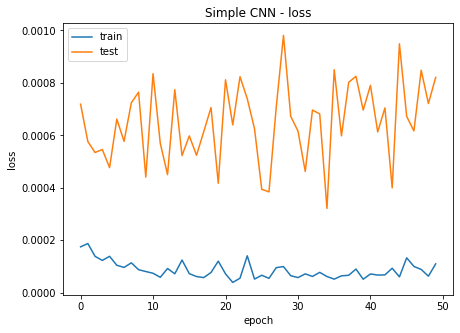

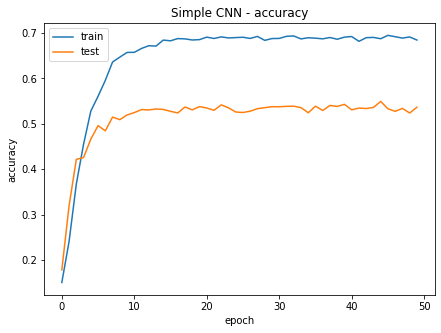

In [124]:
def plot_metric(train, test, metric, title):
    plt.figure(figsize = (7, 5))

    train = torch.tensor(train, device='cpu')
    test = torch.tensor(test, device='cpu')

    with torch.no_grad():
        plt.plot(range(len(train)), train, label = "train")
        plt.plot(range(len(test)), test, label = "test")
    plt.title(title)
    plt.xlabel('epoch')
    plt.ylabel(metric)
    plt.legend()

    # plt.savefig(f'{title}.png')
    plt.show()


plot_metric(loss_train, loss_test, 'loss', 'Simple CNN - loss')
plot_metric(accuracy_train, accuracy_test, 'accuracy', 'Simple CNN - accuracy')

Text(87.0, 0.5, 'Actual')

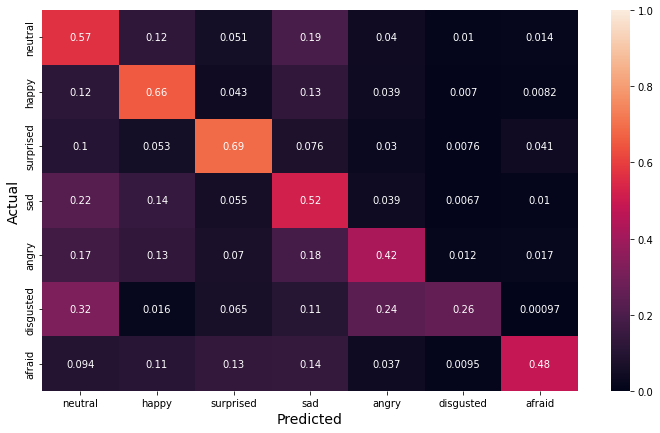

In [125]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd


counts = np.array([(np.array(y_actual) == i).sum() for i in range(NUM_CLASSES)]).reshape(-1, 1)
cf_matrix = confusion_matrix(y_actual, y_pred)
cf_matrix_norm = cf_matrix / counts

df_cm = pd.DataFrame(cf_matrix_norm, index = CLASSES, columns = CLASSES)
plt.figure(figsize = (12,7))
s = sns.heatmap(df_cm, annot=True, cmap=sns.color_palette("rocket", as_cmap=True), vmin=0, vmax=1)
s.set_xlabel('Predicted', fontsize=14)
s.set_ylabel('Actual', fontsize=14)

# plt.savefig('confusion_matrix.png')